In [ ]:
from sklearn.datasets import load_svmlight_file
import torch
import matplotlib.pyplot as plt

: 

In [2]:
from torch.utils.data import Dataset, DataLoader
# LIBSVM dataset
class LIBSVM(torch.utils.data.Dataset):
    def __init__(self, path):
        super().__init__()
        # Load the dataset
        data, targets = load_svmlight_file(path, n_features = 123)

        # Convert targets for values in {0, 1}
        targets = (targets + 1) / 2
        
        # Convert to PyTorch tensors
        data = torch.from_numpy(data.toarray()).float()
        targets = torch.from_numpy(targets).float()

        self.data = data
        self.targets = targets
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        return self.data[index], self.targets[index]

    
# Create datasets and dataloaders
train_path = './libsvm_data/a9a.txt'
test_path = './libsvm_data/a9a_t.txt'

train_dataset = LIBSVM(train_path)
test_dataset = LIBSVM(test_path)

In [3]:
train_dataset.targets

tensor([0., 0., 0.,  ..., 0., 0., 1.])

In [4]:
class libsvm_model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = torch.nn.Linear(123, 1)
    
    def forward(self, x):
        x = self.linear(x)
        return torch.sigmoid(x)


In [ ]:
# Hyperparams
lr = 1e-2
weight_decay = 1e-5
batch_size = len(train_dataset)

# DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
#test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Model
model = libsvm_model()
model.load_state_dict(torch.load('best_model_parameters.pth'))

# Loss and Optimizer
loss_fn = torch.nn.BCELoss()

optimizer = torch.optim.SGD(params= model.parameters(), lr = lr, weight_decay= weight_decay)

def criterion(output, targets):
    # return a tensor of shape (1, 2), where [number of correct pred, batch_size]
    # Transform all values of preds to 0 (if value < 0.5) and 1
    preds = 1 * (output > torch.ones_like(output).mul_(0.5))
    
    return torch.tensor([(preds.view(1, -1).int() == targets.int()).sum(), len(targets)])

def evaluate(output, targets):
    accuracy = criterion(output, targets)
    return accuracy[0].item() / accuracy[1].item()

: 

tensor(0.7512, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.7505, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.7499, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.7492, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.7485, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.7478, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.7472, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.7465, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.7459, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.7452, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.7445, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.7439, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.7432, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.7426, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.7419, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.7413, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.7406, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.7400, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.7393, grad_fn=<Bina

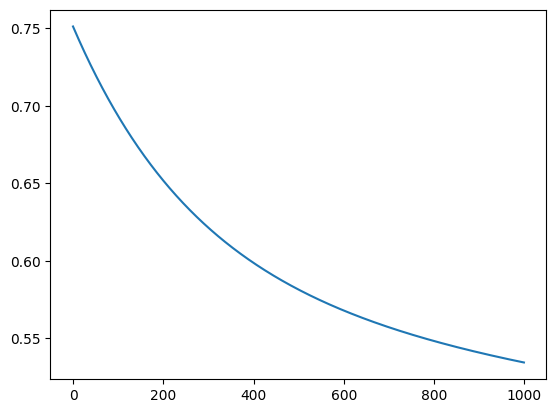

In [9]:
# Training
epochs = 1000
track_loss = []
model.train(True)
for epoch in range(epochs):
    # Gradient descent
    X, y = next(iter(train_dataloader))
    optimizer.zero_grad()
    loss = loss_fn(model(X), y.view(-1, 1))
    print(loss)
    loss.backward()
    optimizer.step()
    track_loss.append(loss.detach().numpy())

plt.plot(track_loss)

tensor(0.3646, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3646, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3646, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3646, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3646, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3646, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3646, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3646, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3646, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3646, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3646, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3646, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3646, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3646, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3646, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3646, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3646, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3645, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3645, grad_fn=<Bina

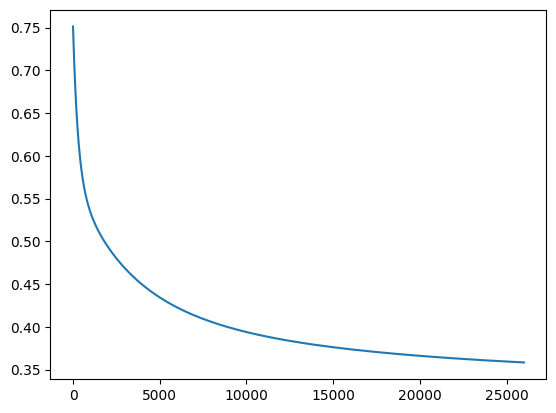

In [17]:
# Training continuity
epochs = 5000
for epoch in range(epochs):
    # Gradient descent
    X, y = next(iter(train_dataloader))
    optimizer.zero_grad()
    loss = loss_fn(model(X), y.view(-1, 1))
    print(loss)
    loss.backward()
    optimizer.step()
    track_loss.append(loss.detach().numpy())

plt.plot(track_loss)

In [18]:
# save model weights for more optimization
torch.save(model.state_dict(), 'best_model_parameters.pth')

# Load the model parameters from the file
loaded_model = libsvm_model()
loaded_model.load_state_dict(torch.load('best_model_parameters.pth'))

<All keys matched successfully>

In [75]:
# Testing
accuracy = torch.zeros(2)
model.eval()
for i, data in enumerate(test_dataloader):
    X, y = data
    accuracy += criterion(model(X), y)
    #print(loss_fn(model(X), y))
    #print(criterion(model(X), y))

print(f"The result of the evaluation over the test set is {accuracy[0].item() / accuracy[1].item()}")

The result of the evaluation over the test set is 0.850316319636386
